In [1]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
from natsort import natsorted


2024-12-11 15:14:09.347948: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 15:14:09.472978: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 15:14:09.578790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733926449.676700  101772 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733926449.708448  101772 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 15:14:09.943387: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# use cpu
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [3]:
# Paths
train_dir = '/home/rafal/Dokumenty/projekty/ml-zoomcamp-2024/capstone/har/train'
test_dir = '/home/rafal/Dokumenty/projekty/ml-zoomcamp-2024/capstone/har/test'
csv_train = '/home/rafal/Dokumenty/projekty/ml-zoomcamp-2024/capstone/har/Training_set.csv'
csv_test = '/home/rafal/Dokumenty/projekty/ml-zoomcamp-2024/capstone/har/Training_set.csv'



In [4]:

def load_features_from_csv(csv_path):
    """
    Loads features from a CSV file into a dictionary.

    Args:
        csv_path (str): Path to the CSV file.

    Returns:
        dict: Dictionary mapping image filenames to their features.
    """
    df = pd.read_csv(csv_path)
    return {os.path.splitext(row['filename'])[0]: row['label'] for _, row in df.iterrows()}


In [5]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [6]:
features_train = load_features_from_csv(csv_train)
features_test = load_features_from_csv(csv_test)




In [7]:
train_dir = pathlib.Path(train_dir).with_suffix('')
test_dir = pathlib.Path(test_dir).with_suffix('')

sorted_train_files = natsorted(list(train_dir.glob('*.jpg')))
sorted_train_file_paths = [str(file) for file in sorted_train_files]

sorted_test_files = natsorted(list(test_dir.glob('*.jpg')))
sorted_test_file_paths = [str(file) for file in sorted_test_files]

train_labels = [features_train[os.path.basename(path).split('.')[0]] for path in sorted_train_file_paths]
test_labels = [features_test[os.path.basename(path).split('.')[0]] for path in sorted_test_file_paths]




In [8]:
label_train_to_index = {name: index for index, name in enumerate(sorted(set(train_labels)))}
train_labels = [label_train_to_index[label] for label in train_labels]
num_classes = len(label_train_to_index)
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)

In [9]:
label_test_to_index = {name: index for index, name in enumerate(sorted(set(test_labels)))}
test_labels = [label_test_to_index[label] for label in test_labels]
num_classes = len(label_test_to_index)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

In [10]:
image_paths_train_ds = tf.data.Dataset.from_tensor_slices(sorted_train_file_paths)
labels_train_ds = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

image_paths_test_ds = tf.data.Dataset.from_tensor_slices(sorted_test_file_paths)
labels_test_ds = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

2024-12-11 15:14:28.154294: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-11 15:14:28.154353: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: szu
2024-12-11 15:14:28.154365: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: szu
2024-12-11 15:14:28.154494: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 470.256.2
2024-12-11 15:14:28.154535: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 470.256.2
2024-12-11 15:14:28.154545: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 470.256.2


In [11]:
train_labels_one_hotdf_train_labels = pd.DataFrame(train_labels_one_hot)

In [11]:

# Map the image loading function to the dataset
image_train_ds = image_paths_train_ds.map(lambda x: load_and_preprocess_image(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)
image_test_ds = image_paths_test_ds.map(lambda x: load_and_preprocess_image(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Combine the image and label datasets
train_dataset = tf.data.Dataset.zip((image_train_ds, labels_train_ds))
test_dataset = tf.data.Dataset.zip((image_test_ds, labels_test_ds))

BATCH_SIZE = 16
train_dataset = train_dataset.shuffle(buffer_size=len(sorted_train_files))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# test_dataset = test_dataset.shuffle(buffer_size=len(sorted_test_files))
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [13]:
def check_dataset_input_shape(dataset):
    for images, labels in dataset.take(1):
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)

# Check the input shape of the training dataset
check_dataset_input_shape(train_dataset)

# Check the input shape of the test dataset
check_dataset_input_shape(test_dataset)

Images shape: (16, 224, 224, 3)
Labels shape: (16, 15)


2024-12-11 15:14:57.445744: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Images shape: (16, 224, 224, 3)
Labels shape: (16, 15)


2024-12-11 15:14:57.958799: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
label_test_to_index_rev = {v: k for k, v in label_test_to_index.items()}

In [15]:
label_test_to_index_rev

{0: 'calling',
 1: 'clapping',
 2: 'cycling',
 3: 'dancing',
 4: 'drinking',
 5: 'eating',
 6: 'fighting',
 7: 'hugging',
 8: 'laughing',
 9: 'listening_to_music',
 10: 'running',
 11: 'sitting',
 12: 'sleeping',
 13: 'texting',
 14: 'using_laptop'}

2024-12-11 14:57:12.792707: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


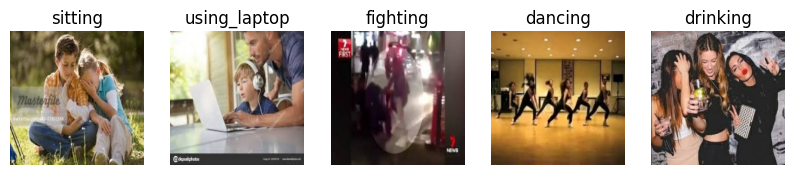

In [17]:
def display_images_with_labels(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(label_test_to_index_rev[np.argmax(labels[i].numpy())])  # Display the class index
            plt.axis("off")

# Display 5 images with labels from the training dataset
display_images_with_labels(train_dataset, 5)

In [16]:
df = pd.DataFrame(train_labels, columns=['Numbers'])

In [17]:
df

,Numbers
0,11
1,14
2,7
3,12
4,14
...,...
12595,11
12596,1
12597,11
12598,3


In [18]:
num_classes = df.value_counts().count()

In [ ]:
# num_classes = 15

In [ ]:
# model = Sequential([
#     layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224, 3)),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(num_classes)    
# ])

/home/rafal/Dokumenty/projekty/ml-zoomcamp-2024/midterm/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(224, 224, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(15)
# ])

/home/rafal/Dokumenty/projekty/ml-zoomcamp-2024/midterm/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.5),  # Add dropout to prevent overfitting
#     tf.keras.layers.Dense(num_classes, activation='softmax')  # Ensure the output layer matches the number of classes
# ])

/home/rafal/Dokumenty/projekty/ml-zoomcamp-2024/midterm/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(num_classes, activation='softmax')  # Ensure the output layer matches the number of classes
# ])

/home/rafal/Dokumenty/projekty/ml-zoomcamp-2024/midterm/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',  # Use categorical crossentropy for one-hot encoded labels
#               metrics=['accuracy'])

In [ ]:
# model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,448,175 (24.60 MB)

 Trainable params: 6,448,175 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
epochs=2
history = model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=epochs
)

Epoch 1/2
  1/788 ━━━━━━━━━━━━━━━━━━━━ 1:12:08 6s/step - accuracy: 0.0625 - loss: 3.8742

: 

In [ ]:
# epochs=10
# history = model.fit(
#   train_dataset,
#   validation_data=test_dataset,
#   epochs=epochs
# )

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 15)